## Задание 1
Считаем необходимые для выполнения задания библиотеки:

In [1]:
import pandas as pd
import requests
from urllib.parse import urlencode

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from scipy import stats
import numpy as np

base_url позволит нам считать csv-файл напрямую с Yandex Cloud без скачивания файла:

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

Создаем запрос к Yandex Cloud для доступа к groups.csv:

In [3]:
public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ' 
final_url_groups = base_url + urlencode(dict(public_key=public_key_groups)) 
response_groups = requests.get(final_url_groups) 
download_url_groups = response_groups.json()['href'] 

Загружаем groups.csv в датафрейм:

In [4]:
download_response = requests.get(download_url_groups)
groups = pd.read_csv(download_url_groups, sep=';') 

Проверяем корректное считывание файла и его характеристики:

In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [6]:
groups.shape

(74484, 2)

In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

In [8]:
groups.isna().sum()

id     0
grp    0
dtype: int64

Проводим аналогичную процедуру для groups_add.csv, active_studs.csv, checks.csv:

In [9]:
public_key_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add)) 
response_groups_add = requests.get(final_url_groups_add)
download_url_groups_add = response_groups_add.json()['href'] 

In [10]:
download_response = requests.get(download_url_groups_add)
groups_add = pd.read_csv(download_url_groups_add, sep=',') 

In [11]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
groups_add.shape

(92, 2)

In [13]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs)) 
response_active_studs = requests.get(final_url_active_studs) 
download_url_active_studs = response_active_studs.json()['href'] 

In [16]:
download_response = requests.get(download_url_active_studs)
active_studs = pd.read_csv(download_url_active_studs, sep=';') 

In [17]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
active_studs.shape

(8341, 1)

In [19]:
active_studs.dtypes

student_id    int64
dtype: object

In [20]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [21]:
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA' 
final_url_checks = base_url + urlencode(dict(public_key=public_key_checks)) 
response_checks = requests.get(final_url_checks) 
download_url_checks = response_checks.json()['href'] 

In [22]:
download_response = requests.get(download_url_checks)
checks = pd.read_csv(download_url_checks, sep=';') 

In [23]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [24]:
checks.shape

(541, 2)

In [25]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [26]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [27]:
checks = checks.rename(columns={'student_id': 'id'})

Соединяем в один датафрейм groups и groups_add:

In [28]:
full_groups = [groups, groups_add]
full_groups = pd.concat(full_groups)

Проверяем, что все соединилось корректно:

In [29]:
full_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [30]:
full_groups.shape

(74576, 2)

Исходя из имеющихся данных, мы изучим следующие метрики:

- количество участников эксперимента в обеих группах, число из них вошедших на платформу и доля вошедших на сайт к общему числу;
- общая сумма трат за дни эксперимента в каждой группе;
- размер среднего чека в каждой группе.

Выясняем общее количество человек в контрольной и тестовой группах:

In [31]:
full_grps = full_groups.groupby('grp', as_index=False).id.nunique()
full_grps

,grp,id
0,A,14693
1,B,59883


Выделяем из всех участников тех, кто зашел на сайт в период проведения эксперимента:

In [32]:
active_studs_groups = full_groups.query('id in @active_studs.student_id')

In [33]:
active_studs_groups.head()

,id,grp
1,1627,A
10,2085,B
12,2215,B
43,3391,A
45,3401,B


In [34]:
active_studs_groups.shape

(8341, 2)

Выясняем, сколько из зашедших на сайт относятся к контрольной и тестовой группе:

In [35]:
active_grps = active_studs_groups.groupby('grp', as_index=False).id.nunique()
active_grps

,grp,id
0,A,1538
1,B,6803


Объединим таблицу checks с active_studs_groups, чтобы далее выяснить количество покупок у пользователей, вошедших на платформу:

In [36]:
active_studs_checks = checks.merge(active_studs_groups, on='id', how='outer')
active_studs_checks.isna().sum()

id        0
rev    7949
grp     149
dtype: int64

Выясняем, что не все активные пользователи совершили покупку в дни эксперимента и не все покупки совершены активными пользователями.

Таким образом, добавляем новую метрику: количество и доля активных пользователей, совершивших покупку в дни эксперимента.

Подготовим таблицу с активными пользователями, которые совершили покупку в дни эксперимента:

In [37]:
active_studs_checks = active_studs_checks.fillna(0)
active_groups_checks = active_studs_checks.query('rev != 0 & grp != 0')
active_grps_checks = active_groups_checks.groupby('grp', as_index=False).agg({'id': 'count'})

График общего количества участников, соотношение зашедших на платформу в каждой группе и совершивших покупку:

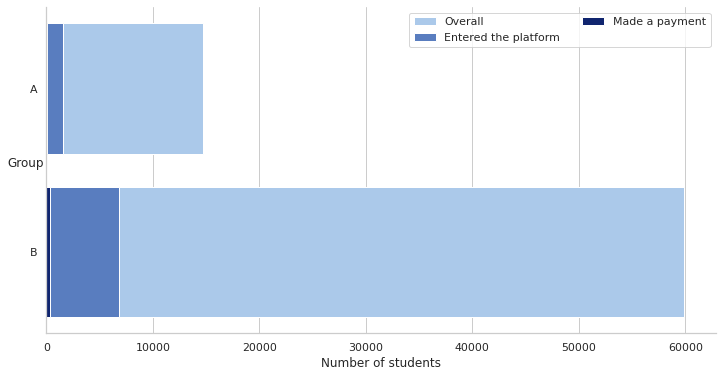

In [38]:
f, ax = plt.subplots(figsize=(12, 6))

sns.set_color_codes("pastel")
sns.barplot(data=full_grps, x='id', y='grp', color='b', label='Overall', ci=None)

sns.set_color_codes("muted")
sns.barplot(data=active_grps, x='id', y='grp', color='b', label='Entered the platform', ci=None)

sns.set_color_codes("dark")
sns.barplot(data=active_grps_checks, x='id', y='grp', color='b', label='Made a payment', ci=None)

plt.xlabel('Number of students')
plt.ylabel('Group', rotation=0)

ax.legend(ncol=2, loc="best", frameon=True)

sns.despine()

В экспериментальной группе гораздо больше как общее количество участников, так и число вошедших на платформу. Однако сложно оценить долю вошедших на сайт. На глаз она, приблизительно, равна в обеих группах. Уточняем эту метрику:

In [39]:
active_grps.id / full_grps.id * 100

0    10.467570
1    11.360486
Name: id, dtype: float64

На графике невозможно оценить долю активных пользователей, совершивших покупку в дни эксперимента. Вычислим её:

In [40]:
active_grps_checks.id / active_grps.id * 100

0    5.071521
1    4.615611
Name: id, dtype: float64

В тестовой группе больше и общее число участников, и количество зашедших на платформу, и их доля. Однако доля совершивших покупку ниже. 

Сравним группы по количеству активных пользователей, совершивших и не совершивших покупку в дни эксперимента. Для этого воспользуемся хи-квадратом, т.к. данные - категориальные:

In [41]:
active_studs_checks['paid'] = active_studs_checks.rev.apply(lambda x: 'yes' if x > 0 else 'no')
group_payment = pd.crosstab(active_studs_checks.query('grp != 0').grp, active_studs_checks.query('grp != 0').paid)
group_payment

paid,no,yes
grp,,
A,1460,78
B,6489,314


In [42]:
stat, p, dof, expected = stats.chi2_contingency(group_payment)
p

0.48625240457231045

p-value > 0.05, значит, группы не различаются статистически по количеству активных пользователей, совершивших и не совершивших покупку в дни эксперимента.

Поскольку, как мы ранее выяснили, в тестовой группе гораздо больше участников, чем в контрольной, то не имеет смысла смотреть метрику общей суммы покупок. Однако релевантно выяснить размер среднего чека в группах активных участников, совершивших покупку за дни эксперимента.

In [43]:
control_checks = active_groups_checks.query('grp == "A"')
control_mean_check = control_checks.rev.mean()
control_mean_check

933.5897435897435

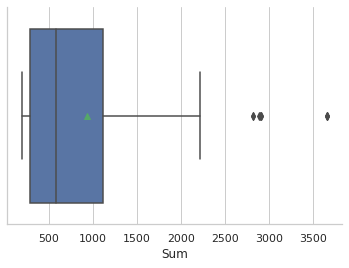

In [44]:
sns.boxplot(x=control_checks.rev, showmeans=True)
plt.xlabel('Sum')
sns.despine()

Построим график и проверим нормальность распределения стоимости покупок участников из контрольной группы:

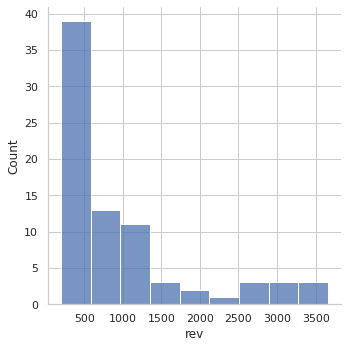

In [45]:
sns.displot(data=control_checks, x='rev')
sns.despine()

In [46]:
stats.normaltest(control_checks.rev)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

Т.к. распределение ненормальное, пробуем нормализовать его с помощью логарифмирования:

In [47]:
stats.normaltest(np.log(control_checks.rev))

NormaltestResult(statistic=7.9915399191892345, pvalue=0.018393278875655582)

Но и это не помогает

Делаем аналогичные процедуры для тестовой группы:

In [48]:
test_checks = active_groups_checks.query('grp == "B"')
test_mean_check = test_checks.rev.mean()
test_mean_check

1257.8789920382164

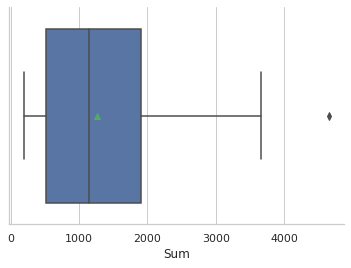

In [49]:
sns.boxplot(x=test_checks.rev, showmeans=True)
plt.xlabel('Sum')
sns.despine()

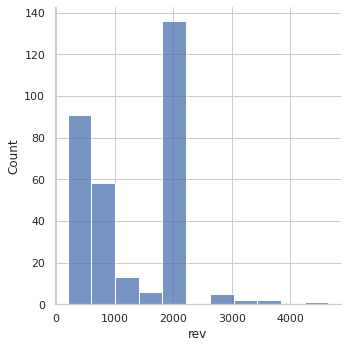

In [50]:
sns.displot(data=test_checks, x='rev')
sns.despine()

In [51]:
stats.normaltest(test_checks.rev)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

In [52]:
stats.normaltest(np.log(test_checks.rev))

NormaltestResult(statistic=85.32513110701674, pvalue=2.9640341038161647e-19)

Мы не знаем наверняка; однако, увеличение среднего чека может быть связано не с ростом трат клиентов, а с увеличением стоимости услуг. Выясним, во сколько средний чек в тестовой группе больше чека в контрольной:

In [71]:
test_mean_check / control_mean_check

1.3473573383545852

Поскольку в обеих группах распределение размеров чека ненормальное, то воспользуемся бутстрепом, чтобы сравнить их. Для этого просимулируем эксперимент в каждой группе 10000 раз с повторениями, вычислим средние значения в этих симуляциях, вычтем средние контрольной группы из средних тестовой и посмотрим 95%-ый доверительный интервал разницы средних в группах:

In [54]:
mean_diff = []
for i in range(10000):
    sample_data_control = control_checks.rev.sample(frac=1, replace=True)
    sample_mean_control = sample_data_control.mean()
    
    sample_data_test = test_checks.rev.sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.mean()
    
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff.append(sample_mean_diff)
    
low = round(pd.Series(mean_diff).quantile(0.025), 2)
high = round(pd.Series(mean_diff).quantile(0.975), 2)
print(f'The confidence interval for the difference between means in the test and control groups is from {low} to {high}')

The confidence interval for the difference between means in the test and control groups is from 98.48 to 536.25


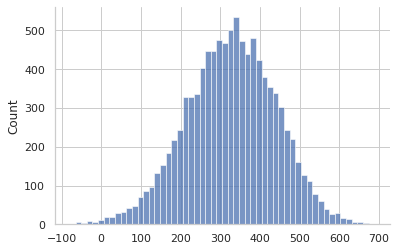

In [55]:
mean_diff_df = pd.DataFrame(mean_diff)
sns.histplot(mean_diff_df, legend=False)
sns.despine()

Поскольку доверительный интервал разницы средних между тестовой и контрольной группой не включает 0 и даже не близок к нему, то среднее в тестовой группе существенно больше и различия достоверны.
#### Таким образом, как количество вошедших на сайт участников эксперимента и их доля от общего числа участников в каждой группе, так и средний чек больше в тестовой группе. Однако доля активных участников, совершивших покупку, в тестовой группе ниже.
### Вывод: нельзя сделать однозначный вывод о введении новой механики оплаты

## Задание 2
### Часть 1
Для работы в Clickhouse через Jupyter Notebook сначала необходимо импортировать библиотеку pandahouse и авторизоваться в системе:

In [56]:
import pandahouse as ph

In [57]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

В задаче стоит условие выяснить количество студентов, правильно выполнивших задание за текущий месяц. Проверим за какой промежуток времени у нас имеются данные. Составим запрос так, как мы бы его написали в Clickhouse на SQL:

In [58]:
q_interval = '''
    SELECT
        toDateTime(MIN(timest)) AS datetime_min,
        toDateTime(MAX(timest)) AS datetime_max
    FROM peas
    '''

Отправляем этот запрос в систему с помощью команды из библиотеки:

In [59]:
interval = ph.read_clickhouse(query=q_interval, connection=connection_default)
interval

,datetime_min,datetime_max
0,2021-10-30 13:00:00,2021-10-31 17:29:52


Выясняем, что наши данные – за одни сутки с 30.10.2021 по 31.10.2021. Значит, делать разбивку по месяцам в данном случае не нужно.

Составляем и отправляем запрос о количество студентов, правильно выполнивших 20 и более "горошин". Для этого сначала необходимо составить подзапрос об отдельных студентах, сделавших 20+ заданий. И уже после этого посчитать общее количество уникальных студентов:

In [60]:
q_studs = '''
    SELECT
       COUNT(DISTINCT st_id) AS brilliant_students
    FROM(
        SELECT
            st_id,
            SUM(correct) AS correct
        FROM peas
        GROUP BY st_id
        HAVING correct >= 20
        )
    '''

studs = ph.read_clickhouse(query=q_studs, connection=connection_default)
studs

,brilliant_students
0,136


### Часть 2
#### ARPU
Поскольку информация о принадлежности пользователя к группе содержится в таблице studs, а сумма покупки — в final_project_check, необходимо выполнить их джойн. Группируем получившиеся данные по группе и вычисляем среднюю сумму покупки. Чтобы привести сумму к денежному формату, округляем до двух знаков после запятой: 

In [61]:
q_arpu = '''
    SELECT
        A.test_grp AS test_grp,
        ROUND(AVG(B.money), 2) AS ARPU
    FROM studs AS A
    JOIN 
        final_project_check AS B
    ON A.st_id = B.st_id
    GROUP BY test_grp
    '''

arpu = ph.read_clickhouse(query=q_arpu, connection=connection_default)
arpu

,test_grp,ARPU
0,control,76944.44
1,pilot,78953.49


#### ARPAU
Для вычисления ARPAU нам необходимы все три таблицы и их джойн. В первом запросе обращаемся к таблице peas, из которой извлекаем число активных пользователей, т.е. решивших правильно более 10 задач. Затем определяем их принадлежность к группе, поджойнив с таблицей studs по колонке st_id. После этого вычисляем среднюю сумму покупки в каждой группе, поджойнив с таблицей final_project_check по колонке st_id:

In [62]:
q_arpau = '''
    SELECT
        C.test_grp,
        ROUND(AVG(D.money), 2) AS ARPAU
    FROM(
        SELECT
            A.st_id,
            B.test_grp
        FROM
            (SELECT
                st_id,
                SUM(correct) AS correct
            FROM peas
            GROUP BY st_id
            HAVING correct > 10
            ) AS A
        JOIN studs AS B
        ON A.st_id = B.st_id
        ) AS C
    JOIN final_project_check AS D
    ON C.st_id = D.st_id
    GROUP BY C.test_grp
    '''

arpau = ph.read_clickhouse(query=q_arpau, connection=connection_default)
arpau

,test_grp,ARPAU
0,control,77647.06
1,pilot,81571.43


#### CR
Чтобы вычислить конверсию посетителей в покупку (conversion rate, CR) необходимо разделить количество уникальных клиентов на общее количество посетителей. Второе число можно извлечь из таблицы peas, где хранятся данные обо всех посетителях платформы. 

Количество посетителей, оформивших покупку, из числа посетителей можно из таблицы final_project_check. LEFT OUTER JOIN позволяет нам получить число всех посетителей платформы в таблице peas и число из них, оформивших покупку.

Далее делим число уникальных клиентов на число уникальных пользователей. Затем умножаем получившееся число на 100 и округляем до двух знаков, чтобы привести в процентный формат:

In [63]:
q_cr = '''
    SELECT
        ROUND(COUNT(DISTINCT B.st_id) / COUNT(DISTINCT A.st_id) * 100, 2) AS CR
    FROM peas AS A
    LEFT OUTER JOIN final_project_check AS B
    ON A.st_id = B.st_id
    '''

cr = ph.read_clickhouse(query=q_cr, connection=connection_default)
cr

,CR
0,14.94


#### CR активных пользователей
Чтобы получить конверсию активных пользователей в покупку, добавляем в предыдущий запрос агрегацию количества правильных ответов:

In [64]:
q_active_users_cr = '''
    SELECT
        ROUND(COUNT(DISTINCT B.st_id) / COUNT(DISTINCT A.st_id) * 100 , 2) AS active_users_CR
    FROM(
        SELECT st_id
        FROM peas
        GROUP BY st_id
        HAVING SUM(correct) > 10
        ) AS A
    LEFT OUTER JOIN final_project_check AS B
    ON A.st_id = B.st_id
    '''

active_users_cr = ph.read_clickhouse(query=q_active_users_cr, connection=connection_default)
active_users_cr

,active_users_CR
0,17.94


#### CR активных пользователей по математике в покупку курса по математике
Чтобы вычислить этот показатель, сначала определяем активных пользователей по математике в таблице peas. Затем джойним эту таблицу с таблицей final_project_check по id студентов и предмету. После делим количество клиентов на количество активных пользователей по математике и переводим в процентный формат:

In [65]:
q_active_users_CR_math = '''
    SELECT
        ROUND(COUNT(DISTINCT B.st_id) / COUNT(DISTINCT A.st_id) * 100, 2) AS active_users_math_CR
    FROM(
        SELECT
            st_id,
            subject
        FROM peas
        WHERE subject = 'Math'
        GROUP BY st_id, subject
        HAVING SUM(correct) >= 2
        ) AS A
    LEFT OUTER JOIN final_project_check AS B
    ON A.st_id = B.st_id AND A.subject = B.subject
    '''

active_users_CR_math = ph.read_clickhouse(query=q_active_users_CR_math, connection=connection_default)
active_users_CR_math

,active_users_math_CR
0,8.79


## Задание 3
### Часть 1

In [66]:
def groups_add(public_key):
    '''
    Определяем функция groups_add(public_key), где public_key – переменная, содержащая ссылку на данные, которые нужно подгрузить

    Сначала создаем final_url, который состоит из base_url, ссылки api, и переведенного в формат ссылки public_key.

    Далее делаем запрос к Yandex Cloud для получения данных и считываем csv-файл.

    Затем объединяем исходный датафрейм groups с новым датафреймом groups_add.

    После рассчитываем количество уникальных пользователей в контрольной и тестовой группе в таблице full_grps и печатаем получившиеся расчеты.
    
    Таблицу делаем глобальной, чтобы использовать ее в дальнейшем.

    В продолжение вычисляем количество активных пользователей, выделив в датафрейме full_grps только активных пользователей, обратившись к id студентов в датафрейме active_studs.
    
    И так же определяем их количество в каждой группе. И печатаем этот расчет.
    
    Таблицу active_grps делаем глобальной, чтобы использовать ее в дальнейшем.

    Считаем долю активных пользователей, разделив датафрейм active_grps с активными пользователями на full_grps со всеми пользователями;
    затем переводим получившиеся числа в процентный формат и выводим на печать.

    Обратившись к таблице checks и выделив из нее студентов из контрольной и тестовой группы, рассчитываем средний размер чека в каждой группе и печатаем эту информацию.
    
    Таблицы control_checks и test_checks делаем глобальными, чтобы использовать их в дальнейшем.
    '''
    
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url)
    download_url = response.json()['href'] 
    
    groups_add = pd.read_csv(download_url, sep=',')
    
    full_groups = [groups, groups_add]
    full_groups = pd.concat(full_groups)
    
    global full_grps
    full_grps = full_groups.groupby('grp', as_index=False).id.nunique()
    print(f'The entire number of students in the control and test groups is equal to: {full_grps}\n')
    
    global active_grps
    active_studs_groups = full_groups.query('id in @active_studs.student_id')
    active_grps = active_studs_groups.groupby('grp', as_index=False).id.nunique()
    print(f'The number of active students in the control and test groups is equal to: {active_grps}\n')
    
    global active_grps_checks
    active_studs_checks = checks.merge(active_studs_groups, on='id', how='outer')
    active_studs_checks = active_studs_checks.fillna(0)
    active_groups_checks = active_studs_checks.query('rev != 0 & grp != 0')
    active_grps_checks = active_groups_checks.groupby('grp', as_index=False).agg({'id': 'count'})
    print(f'The number of active students who made a purchase in the control and test groups is {active_grps_checks}\n')
    
    active_studs_share = pd.Series(round(active_grps.id / full_grps.id * 100, 2))
    print(f'The share of active students in the control and test groups is equal to: {active_studs_share}\n')
    
    groups_purchase_share = pd.Series(round(active_grps_checks.id / active_grps.id * 100, 2))
    print(f'The share of active students who made a purchase in the control and test groups is {groups_purchase_share}\n')
    
    global control_checks
    control_checks = active_groups_checks.query('grp == "A"')
    control_mean_check = round(control_checks.rev.mean(), 2)
    print(f'The mean sum in the test group is equal to {control_mean_check}\n')
    
    global test_checks
    test_checks = active_groups_checks.query('grp == "B"')
    test_mean_check = round(test_checks.rev.mean(), 2)
    print(f'The mean sum in the control group is equal to {test_mean_check}')

Задаем значение переменной public_key и реализуем функцию groups_add от переменной public_key:

In [67]:
public_key = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
groups_add(public_key)

The entire number of students in the control and test groups is equal to:   grp     id
0   A  14693
1   B  59883

The number of active students in the control and test groups is equal to:   grp    id
0   A  1538
1   B  6803

The number of active students who made a purchase in the control and test groups is   grp   id
0   A   78
1   B  314

The share of active students in the control and test groups is equal to: 0    10.47
1    11.36
Name: id, dtype: float64

The share of active students who made a purchase in the control and test groups is 0    5.07
1    4.62
Name: id, dtype: float64

The mean sum in the test group is equal to 933.59

The mean sum in the control group is equal to 1257.88


### Часть 2

In [68]:
def plots():
    '''
    Для сравнения общего числа пользователей в группах, числа активных пользователей и их долю сделаем горизонтальный барчарт.
    
    Сначала зададим его размеры. Сначала построим график с общим числом пользователей, обратившись к таблице full_grps.
    
    Для него выберем пастельный оттенок синего цвета и обозначим как overall.
    
    Затем поверх построим график с активными пользователями – он будет приглушенного синего цвета и обозначен Entered the platform.
    
    Дадим название самому графику и обозначим, что на оси x и на оси y. Теперь нам удобно сравнивать показатели между собой.
    
    Для сравнения размера среднего чека в каждой группе построим боксплоты, которые нам дадут сведения также и разбросе сумм в чеке.
    
    Строим боксплот с суммами в контрольной группе, обратившись к колонке rev в таблицей control_checks.
    
    После даем название графику и оси x. Проводим аналогичные процедуры для графика чеков в тестовой группе. Зеленым треугольником обозначены средние значения чека. 
    
    Также приведем оси x к одному размеру, чтобы было проще сравнивать графики.
    '''
    
    f, ax = plt.subplots(figsize=(12, 6))

    sns.set_color_codes("pastel")
    sns.barplot(data=full_grps, x='id', y='grp', color='b', label='Overall', ci=None)

    sns.set_color_codes("muted")
    sns.barplot(data=active_grps, x='id', y='grp', color='b', label='Entered the platform', ci=None)
    
    sns.set_color_codes("dark")
    sns.barplot(data=active_grps_checks, x='id', y='grp', color='b', label='Made a payment', ci=None)

    plt.title('Number of students in the groups and the share of active students')
    plt.xlabel('Number of students')
    plt.ylabel('Group', rotation=0)

    ax.legend(ncol=2, loc="best", frameon=True)

    sns.despine()

    m, p = plt.subplots(figsize=(12, 6))
    sns.boxplot(x=control_checks.rev, showmeans=True)
    plt.title('Sums in the control group')
    plt.xlabel('Sum')
    p.set(xlim=(0, 5000))
    sns.despine()
    
    l, k = plt.subplots(figsize=(12, 6))
    sns.boxplot(x=test_checks.rev, showmeans=True)
    plt.title('Sums in the test group')
    plt.xlabel('Sum')
    k.set(xlim=(0, 5000))
    sns.despine()

Реализуем функцию:

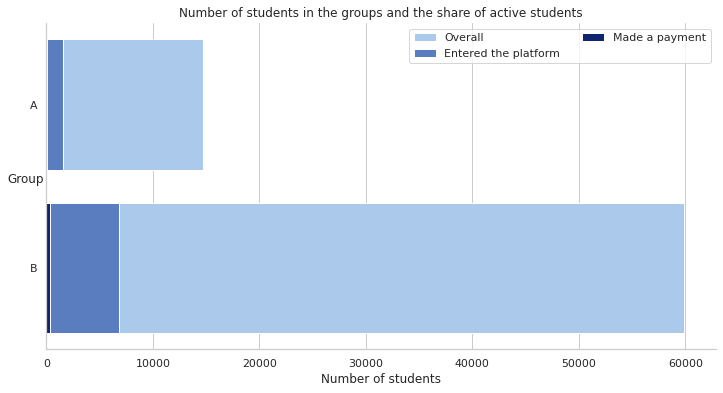

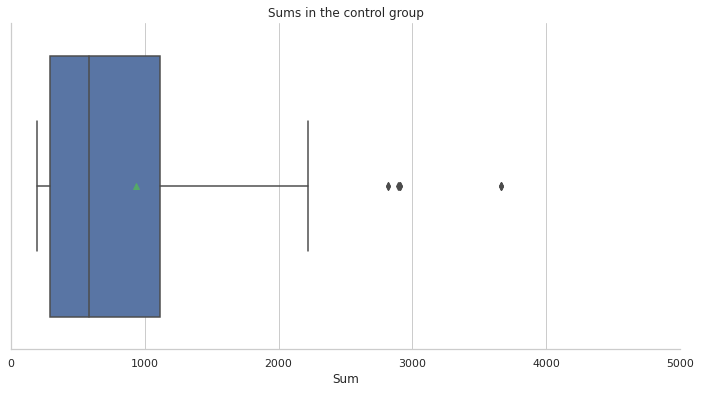

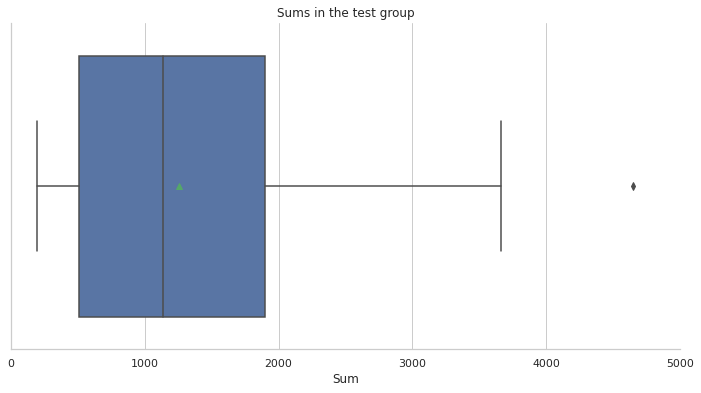

In [69]:
plots()